# EfficientNetB0 Layer Freezing Experiments and Final Training

## PRE-PROCESSING

In [1]:
RUN_MODE = "experiment"

In [2]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Absolute root where train/val/test exist after unzipping
DATA_ROOT = r'/kaggle/input/dataset-split/final_dementia_split'

# Robust per-image normalization
def robust_normalize(image):
    image = image.astype(np.float32) / 255.0
    mask = image > 0
    pixels = image[mask]
    if pixels.size > 0:
        median = np.median(pixels)
        q25, q75 = np.percentile(pixels, [25, 75])
        iqr = q75 - q25
        if iqr > 0:
            image = (image - median) / iqr
    return image

# Data generators
def create_data_generators(batch_size=32):
    common_datagen = ImageDataGenerator(preprocessing_function=robust_normalize)

    train_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'train'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    val_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'validation'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    test_gen = common_datagen.flow_from_directory(
        os.path.join(DATA_ROOT, 'test'),
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_gen, val_gen, test_gen

print('setup data pipeline successfully.')

2026-02-01 11:02:00.884361: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1769943721.135203      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1769943721.221084      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1769943721.831428      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943721.831472      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1769943721.831475      24 computation_placer.cc:177] computation placer alr

setup data pipeline successfully.


In [3]:
#from data_pipeline_setup import create_data_generators
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import os
import json
import random

# Set seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup distributed training
strategy = tf.distribute.MirroredStrategy()
print(f"Number of GPUs: {strategy.num_replicas_in_sync}")

print("TensorFlow version:", tf.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of GPUs: 2
TensorFlow version: 2.19.0
GPU Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


I0000 00:00:1769943738.633405      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1769943738.639330      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


## CONFIGURATION

In [4]:
class Config:
    """Experiment configuration for EfficientNetB0"""
    # Data
    BATCH_SIZE = 32
    IMG_SIZE = (224, 224)
    NUM_CLASSES = 4
    CLASS_NAMES = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

    # Training
    EPOCHS = 5
    LEARNING_RATE = None #will be set later

    # Paths
    RESULTS_DIR = '/kaggle/working/results/efficientnet/'
    MODELS_DIR = '/kaggle/working/models/efficientnet/'

    # Freezing configurations (absolute layer counts) - WILL BE SET MANUALLY AFTER LAYER EXPLORATION
    FREEZE_CONFIGS = [
        {'name': 'freeze_all', 'layers': 237},
        {'name': 'freeze_block7', 'layers': 234},
        {'name': 'freeze_block6', 'layers': 221},
        {'name': 'freeze_block5', 'layers': 162},
        {'name': 'freeze_block4', 'layers': 119},
        {'name': 'freeze_block3', 'layers': 75},
        {'name': 'freeze_block2', 'layers': 46},
        {'name': 'freeze_block1', 'layers': 17},
        {'name': 'freeze_none', 'layers': 0},
    ]

config = Config()

# Create directories
os.makedirs(config.RESULTS_DIR, exist_ok=True)
os.makedirs(config.MODELS_DIR, exist_ok=True)

print('setup config')

setup config


## DATA LOADING

In [5]:

print("\n" + "="*70)
print("LOADING DATA")
print("="*70)

# Load data using your preprocessing pipeline
# Replace this import with your actual preprocessing module
try:
    train_gen, val_gen, test_gen = create_data_generators(batch_size=config.BATCH_SIZE)
    print(f"✓ Data generators created successfully")
    print(f"  Train batches: {len(train_gen)}")
    print(f"  Val batches: {len(val_gen)}")
    print(f"  Test batches: {len(test_gen)}")
except Exception as e:
    print(f"✗ Error loading data: {e}")
    print("\nPlease ensure:")
    print("1. preprocessing.py exists with create_data_generators() function")
    print("2. Data directories are set up correctly")
    raise

# Test data pipeline
print("\nTesting data pipeline...")
try:
    sample_batch, sample_labels = next(iter(train_gen))
    print(f"✓ Sample batch shape: {sample_batch.shape}")
    print(f"✓ Sample labels shape: {sample_labels.shape}")
    print(f"✓ Image value range: [{sample_batch.min():.3f}, {sample_batch.max():.3f}]")
    print(f"✓ Labels (first 5): {sample_labels[:5]}")
except Exception as e:
    print(f"✗ Data pipeline test failed: {e}")
    raise



LOADING DATA
Found 30800 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
Found 6600 images belonging to 4 classes.
✓ Data generators created successfully
  Train batches: 963
  Val batches: 207
  Test batches: 207

Testing data pipeline...
✓ Sample batch shape: (32, 224, 224, 3)
✓ Sample labels shape: (32, 4)
✓ Image value range: [-1.609, 2.087]
✓ Labels (first 5): [[0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


## MODEL ARCHITECTURE EXPLORATION

In [6]:

print("\n" + "="*70)
print("EFFICIENTNETB0 ARCHITECTURE EXPLORATION")
print("="*70)

# Load base model to explore architecture
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

print(f"\nTotal layers in EfficientNetB0: {len(base_model.layers)}")
print("\nFirst 10 layers:")
for i in range(min(10, len(base_model.layers))):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

print("\nLast 10 layers:")
for i in range(max(0, len(base_model.layers)-10), len(base_model.layers)):
    layer = base_model.layers[i]
    trainable_str = "trainable" if layer.trainable else "frozen"
    print(f"  {i:3d}. {layer.name:30s} | {layer.__class__.__name__:20s} | {trainable_str}")

# Save layer information
layer_info = []
for i, layer in enumerate(base_model.layers):
    layer_info.append({
        'index': i,
        'name': layer.name,
        'type': layer.__class__.__name__,
        'trainable': layer.trainable
    })

df_layers = pd.DataFrame(layer_info)
df_layers.to_csv(f'{config.RESULTS_DIR}/efficientnet_layers.csv', index=False)
print(f"\n✓ Layer information saved to {config.RESULTS_DIR}/efficientnet_layers.csv")
print("\n✓ Use the CSV above to identify the exact blocks and layers you want to freeze.")
print("✓ Then manually set FREEZE_CONFIGS with the layer indices.")

print('done')


EFFICIENTNETB0 ARCHITECTURE EXPLORATION
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Total layers in EfficientNetB0: 238

First 10 layers:
    0. input_layer                    | InputLayer           | trainable
    1. rescaling                      | Rescaling            | trainable
    2. normalization                  | Normalization        | trainable
    3. rescaling_1                    | Rescaling            | trainable
    4. stem_conv_pad                  | ZeroPadding2D        | trainable
    5. stem_conv                      | Conv2D               | trainable
    6. stem_bn                        | BatchNormalization   | trainable
    7. stem_activation                | Activation           | trainable
    8. block1a_dwconv                 | DepthwiseConv2D      | trainable
    9. block1a_bn                     | BatchNormalization   | trainable

Last 10 layers:
  228. block7a_se_squeeze             | GlobalAveragePooling2D | trainable
  229. block7a_se_reshape      

## MODEL CREATION FUNCTIONS

In [7]:
#learning rate when more layers are trainable needs to decrease accordingly
def get_learning_rate_for_config(num_frozen_layers, total_layers=237):
    """Calculate learning rate based on number of trainable layers in EfficientNetB0"""
    trainable_layers = total_layers - num_frozen_layers
    trainable_ratio = trainable_layers / total_layers
    
    if trainable_ratio < 0.2:
        return 0.001
    elif trainable_ratio < 0.5:
        return 0.0005
    elif trainable_ratio < 0.8:
        return 0.0001
    else:
        return 0.00005

def create_model(num_frozen_layers=0, num_classes=4):
    """
    Create EfficientNetB0 model with specified number of frozen layers

        num_frozen_layers: Number of layers to freeze from the beginning (0-237)
        num_classes: Number of output classes

    Returns:
        Compiled Keras model
    """
    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3)
    )

    # Freeze specified number of layers
    for i, layer in enumerate(base_model.layers):
        if i < num_frozen_layers:
            layer.trainable = False
        else:
            layer.trainable = True

    # Count trainable parameters
    trainable_count = sum([1 for layer in base_model.layers if layer.trainable])
    frozen_count = len(base_model.layers) - trainable_count

    # Build complete model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ], name=f'efficientnet_freeze_{num_frozen_layers}')

    #set_learning_rate
    lr = get_learning_rate_for_config(num_frozen_layers)
    config.LEARNING_RATE = lr 
        
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=config.LEARNING_RATE, clipnorm=1.0),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print("\nMODEL SUMMARY")
    print("=" * 70)
    model.summary()
    print("=" * 70)

    print(f"EfficientNetB0 Model Created: Freeze {num_frozen_layers} layers")
    print(f"{'─'*70}")
    print(f"  Total base layers: {len(base_model.layers)}")
    print(f"  Frozen layers: {frozen_count}")
    print(f"  Trainable layers: {trainable_count}")
    print(f"  Trainable params: {model.count_params():,}")

    return model

print('created model')


created model


## TRAINING AND EVALUATION FUNCTION

In [8]:
def train_model(model, config_name, train_gen, val_gen, epochs=15):
    """
    Train model with callbacks and save results

    Args:
        model: Compiled Keras model
        config_name: Name of configuration (for saving)
        train_gen: Training data generator
        val_gen: Validation data generator
        epochs: Number of epochs

    Returns:
        history: Training history object
    """
    print(f"\n{'='*70}")
    print(f"TRAINING: {config_name}")
    print(f"{'='*70}")

    if RUN_MODE == "experiment":
        config.EPOCHS = 10
        STEPS_PER_EPOCH = 250
        VAL_STEPS = 100
    elif RUN_MODE == "final":
        config.EPOCHS = 50
        STEPS_PER_EPOCH = None
        VAL_STEPS = None
    else:
        raise ValueError("Invalid RUN_MODE")

    # Callbacks
    callbacks = [
        EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True,
            verbose=1
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=3,
            verbose=1,
            min_lr=1e-7
        ),
        ModelCheckpoint(
            filepath=f'{config.MODELS_DIR}/{config_name}_best.h5',
            monitor='val_accuracy',
            save_best_only=True,
            verbose=1
        )
    ]

    # Train
    start_time = datetime.now()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=config.EPOCHS,
        steps_per_epoch=STEPS_PER_EPOCH,
        validation_steps=VAL_STEPS,
        callbacks=callbacks,
        verbose=1
    )
    
    training_time = (datetime.now() - start_time).total_seconds() / 60

    print(f"\n✓ Training completed in {training_time:.2f} minutes")

    return history, training_time

def evaluate_model(model, config_name, history, training_time, val_gen):
    """
    Evaluate model and save results

    Args:
        model: Trained model
        config_name: Configuration name
        history: Training history
        training_time: Time taken to train (minutes)
        val_gen: Validation generator

    Returns:
        results: Dictionary of results
    """
    # Get best metrics from history
    best_epoch = np.argmax(history.history['val_accuracy'])
    best_val_acc = max(history.history['val_accuracy'])
    best_train_acc = history.history['accuracy'][best_epoch]
    final_val_loss = history.history['val_loss'][best_epoch]

    # Evaluate on validation set
    val_loss, val_acc = model.evaluate(val_gen, verbose=0)

    results = {
        'config_name': config_name,
        'best_epoch': best_epoch + 1,
        'total_epochs': len(history.history['loss']),
        'best_train_accuracy': best_train_acc,
        'best_val_accuracy': best_val_acc,
        'final_val_loss': final_val_loss,
        'training_time_minutes': training_time
    }

    print(f"\n{'─'*70}")
    print(f"RESULTS: {config_name}")
    print(f"{'─'*70}")
    print(f"  Best Epoch: {results['best_epoch']}/{results['total_epochs']}")
    print(f"  Train Accuracy: {results['best_train_accuracy']:.4f}")
    print(f"  Val Accuracy: {results['best_val_accuracy']:.4f}")
    print(f"  Val Loss: {results['final_val_loss']:.4f}")
    print(f"  Training Time: {results['training_time_minutes']:.2f} min")

    # Save training curves
    plot_training_curves(history, config_name)

    return results

print('setup training and evaluation')

setup training and evaluation


## VISUALIZATION FUNCTIONS

In [9]:

def plot_training_curves(history, config_name):
    """Plot and save training curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # Accuracy
    ax1.plot(history.history['accuracy'], label='Train', linewidth=2)
    ax1.plot(history.history['val_accuracy'], label='Validation', linewidth=2)
    ax1.set_title(f'{config_name} - Accuracy', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Accuracy', fontsize=12)
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # Loss
    ax2.plot(history.history['loss'], label='Train', linewidth=2)
    ax2.plot(history.history['val_loss'], label='Validation', linewidth=2)
    ax2.set_title(f'{config_name} - Loss', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('Loss', fontsize=12)
    ax2.legend(fontsize=11)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/{config_name}_curves.png', dpi=150, bbox_inches='tight')
    plt.close()

def plot_comparison(results_df):
    """Plot comparison of all configurations"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Sort by frozen layers
    results_df = results_df.sort_values('frozen_layers')

    # Accuracy comparison
    ax = axes[0, 0]
    x = range(len(results_df))
    ax.plot(x, results_df['best_train_accuracy'], marker='o', linewidth=2, markersize=8, label='Train Accuracy')
    ax.plot(x, results_df['best_val_accuracy'], marker='s', linewidth=2, markersize=8, label='Val Accuracy')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Accuracy', fontsize=12)
    ax.set_title('Accuracy vs Frozen Layers', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3)

    # Validation accuracy bar chart
    ax = axes[0, 1]
    bars = ax.bar(x, results_df['best_val_accuracy'], color='steelblue', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Validation Accuracy', fontsize=12)
    ax.set_title('Validation Accuracy by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    # Highlight best
    best_idx = results_df['best_val_accuracy'].idxmax()
    bars[results_df.index.get_loc(best_idx)].set_color('green')

    # Training time
    ax = axes[1, 0]
    ax.bar(x, results_df['training_time_minutes'], color='coral', alpha=0.7)
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Training Time (minutes)', fontsize=12)
    ax.set_title('Training Time by Configuration', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

    # Overfitting analysis (train - val accuracy)
    ax = axes[1, 1]
    overfitting = results_df['best_train_accuracy'] - results_df['best_val_accuracy']
    bars = ax.bar(x, overfitting, color='orange', alpha=0.7)
    ax.axhline(y=0, color='red', linestyle='--', linewidth=2, label='No Overfitting')
    ax.set_xticks(x)
    ax.set_xticklabels(results_df['config_name'], rotation=45, ha='right')
    ax.set_ylabel('Train Acc - Val Acc', fontsize=12)
    ax.set_title('Overfitting Analysis', fontsize=14, fontweight='bold')
    ax.legend(fontsize=11)
    ax.grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{config.RESULTS_DIR}/comparison_all.png', dpi=150, bbox_inches='tight')
    plt.close()
    print(f"\n✓ Comparison plot saved to {config.RESULTS_DIR}/comparison_all.png")

print('setup viz')

setup viz


## MAIN EXPERIMENT LOOP

In [10]:
def run_all_experiments():
    """Run all layer freezing experiments"""

    print("\n" + "#"*70)
    print("STARTING EFFICIENTNETB0 LAYER FREEZING EXPERIMENTS")
    print("#"*70)
    print(f"\nTotal configurations to test: {len(config.FREEZE_CONFIGS)}")
    print(f"Expected total time: ~{len(config.FREEZE_CONFIGS) * 1.5:.1f} hours (avg 1.5h per config)")

    all_results = []

    for i, freeze_config in enumerate(config.FREEZE_CONFIGS, 1):
        config_name = freeze_config['name']
        num_frozen = freeze_config['layers']

        print(f"\n{'#'*70}")
        print(f"EXPERIMENT {i}/{len(config.FREEZE_CONFIGS)}: {config_name}")
        print(f"{'#'*70}")

        try:
            # Create model
            model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

            # Train model
            history, training_time = train_model(
                model=model,
                config_name=config_name,
                train_gen=train_gen,
                val_gen=val_gen,
                epochs=config.EPOCHS
            )

            # Evaluate and save results
            results = evaluate_model(
                model=model,
                config_name=config_name,
                history=history,
                training_time=training_time,
                val_gen=val_gen
            )

            # Add frozen layers info
            results['frozen_layers'] = num_frozen
            results['trainable_layers'] = len(base_model.layers) - num_frozen

            all_results.append(results)

            # Save intermediate results
            df_results = pd.DataFrame(all_results)
            df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate.csv', index=False)

            # Clear memory
            del model
            tf.keras.backend.clear_session()

            print(f"\n✓ Experiment {i}/{len(config.FREEZE_CONFIGS)} completed successfully")

        except Exception as e:
            print(f"\n✗ Experiment {config_name} failed: {e}")
            continue

    # Final results
    print("\n" + "#"*70)
    print("ALL EXPERIMENTS COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_final.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Best configuration
    best_config = df_results.iloc[0]
    print("\n" + "="*70)
    print("🏆 BEST CONFIGURATION")
    print("="*70)
    print(f"  Configuration: {best_config['config_name']}")
    print(f"  Frozen Layers: {best_config['frozen_layers']}/{len(base_model.layers)}")
    print(f"  Validation Accuracy: {best_config['best_val_accuracy']:.4f}")
    print(f"  Training Accuracy: {best_config['best_train_accuracy']:.4f}")
    print(f"  Overfitting Gap: {best_config['best_train_accuracy'] - best_config['best_val_accuracy']:.4f}")

    # Create comparison plots
    plot_comparison(df_results)

    # Save configuration
    with open(f'{config.RESULTS_DIR}/experiment_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## MAIN TRAINING FUNCTION

In [11]:
def run_main_training(name, layers_freeze):
    """Run final model training"""

    print("\n" + "#"*70)
    print(f"STARTING DENSENET MODEL TRAINING FREEZING {layers_freeze} layers")
    print("#"*70)
    
    all_results = []

    config_name = name
    num_frozen = layers_freeze

    try:
        # Create model
        model = create_model(num_frozen_layers=num_frozen, num_classes=config.NUM_CLASSES)

        # Train model
        history, training_time = train_model(
            model=model,
            config_name=config_name,
            train_gen=train_gen,
            val_gen=val_gen,
            epochs=config.EPOCHS
        )

        # Evaluate and save results
        results = evaluate_model(
            model=model,
            config_name=config_name,
            history=history,
            training_time=training_time,
            val_gen=val_gen
        )

        # Add frozen layers info
        results['frozen_layers'] = num_frozen
        results['trainable_layers'] = len(base_model.layers) - num_frozen

        all_results.append(results)

        # Save intermediate results
        df_results = pd.DataFrame(all_results)
        df_results.to_csv(f'{config.RESULTS_DIR}/results_intermediate_main.csv', index=False)

        # Clear memory
        del model
        tf.keras.backend.clear_session()

    except Exception as e:
        print(f"\n✗ Experiment {config_name} failed: {e}")

    # Final results
    print("\n" + "#"*70)
    print("TRAINING COMPLETED")
    print("#"*70)

    # Save final results
    df_results = pd.DataFrame(all_results)
    df_results = df_results.sort_values('best_val_accuracy', ascending=False)
    df_results.to_csv(f'{config.RESULTS_DIR}/results_main_model.csv', index=False)

    # Display summary
    print("\n" + "="*70)
    print("FINAL RESULTS SUMMARY")
    print("="*70)
    print(df_results[['config_name', 'frozen_layers', 'best_val_accuracy',
                      'best_train_accuracy', 'training_time_minutes']].to_string(index=False))

    # Save configuration
    with open(f'{config.RESULTS_DIR}/main_config.json', 'w') as f:
        json.dump({
            'batch_size': config.BATCH_SIZE,
            'epochs': config.EPOCHS,
            'learning_rate': config.LEARNING_RATE,
            'freeze_configs': config.FREEZE_CONFIGS,
            'timestamp': datetime.now().isoformat()
        }, f, indent=2)

    return df_results

print('done')

done


## BEST MODEL SELECTION FUNCTION

In [12]:
def select_best_model(results_df):
    """
    Intelligent model selection based on:
    1) Peak validation accuracy
    2) Elite group within 0.5% of peak
    3) Generalization gap (Train Acc - Val Acc)
    4) Winner: smallest gap
    5) Tiebreaker: lowest validation loss
    
    Args:
        df_results: DataFrame with experiment results containing columns:
                    - best_val_accuracy
                    - best_train_accuracy
                    - final_val_loss
                    - config_name
                    - frozen_layers
    
    Returns:
        dict: Selected model info with keys:
              - config_name, frozen_layers, best_val_accuracy, best_train_accuracy,
                final_val_loss, generalization_gap, selection_reason
    """
    
    # 1. Peak validation accuracy
    peak_val_acc = results_df['best_val_accuracy'].max()
    peak_val_loss = results_df.loc[results_df['best_val_accuracy'].idxmax(), 'final_val_loss']
    
    print("\n" + "="*70)
    print("MODEL SELECTION ALGORITHM")
    print("="*70)
    print(f"\n1. Peak Validation Accuracy: {peak_val_acc:.4f}")
    
    # 2. Define elite group (within 0.5% of peak)
    threshold = peak_val_acc * 0.995  # 0.5% tolerance
    elite_group = results_df[results_df['best_val_accuracy'] >= threshold].copy()
    
    print(f"\n2. Elite Group Threshold: {threshold:.4f}")
    print(f"   Models in elite group: {len(elite_group)}")
    for idx, row in elite_group.iterrows():
        gap = row['best_train_accuracy'] - row['best_val_accuracy']
        print(f"      - {row['config_name']:20s} | Val Acc: {row['best_val_accuracy']:.4f} | Gap: {gap:+.4f} | Val Loss: {row['final_val_loss']:.4f}")
    
    # 3. Calculate generalization gap for elite group
    elite_group['generalization_gap'] = elite_group['best_train_accuracy'] - elite_group['best_val_accuracy']
    elite_group['abs_gap'] = abs(elite_group['generalization_gap'])
    
    print(f"\n3. Generalization Gap Analysis (Train Acc - Val Acc):")
    for idx, row in elite_group.iterrows():
        print(f"   {row['config_name']:20s} : {row['generalization_gap']:+.4f} (abs: {row['abs_gap']:.4f})")

    # 4. Select winner: smallest absolute gap (closest to zero)
    winner_idx = elite_group['abs_gap'].idxmin()
    winner = elite_group.loc[winner_idx]
    
    selection_reason = f"Smallest abs gap ({winner['generalization_gap']:+.4f})"
    
    # 5. Tiebreaker: if multiple models with same gap, pick lowest val loss
    same_gap = elite_group[elite_group['abs_gap'] == elite_group['abs_gap'].min()]
    if len(same_gap) > 1:
        winner_idx = same_gap['final_val_loss'].idxmin()
        winner = elite_group.loc[winner_idx]
        selection_reason += f", tied → lowest val loss ({winner['final_val_loss']:.4f})"
    
    print("\n" + "="*70)
    print("SELECTED MODEL FOR FINAL TRAINING")
    print("="*70)
    print(f"  Configuration: {winner['config_name']}")
    print(f"  Frozen Layers: {winner['frozen_layers']}")
    print(f"  Val Accuracy: {winner['best_val_accuracy']:.4f}")
    print(f"  Train Accuracy: {winner['best_train_accuracy']:.4f}")
    print(f"  Generalization Gap: {winner['generalization_gap']:.4f}")
    print(f"  Val Loss: {winner['final_val_loss']:.4f}")
    print(f"  Selection Reason: {selection_reason}")
    print("="*70 + "\n")
    
    return {
        'config_name': winner['config_name'],
        'frozen_layers': int(winner['frozen_layers']),
        'best_val_accuracy': winner['best_val_accuracy'],
        'best_train_accuracy': winner['best_train_accuracy'],
        'final_val_loss': winner['final_val_loss'],
        'generalization_gap': winner['generalization_gap'],
        'selection_reason': selection_reason
    }

print('setup model selection function')

setup model selection function


## QUICK TEST FUNCTION

In [13]:

def test_pipeline():
    """Quick test to verify everything works before running full experiments"""
    print("\n" + "="*70)
    print("RUNNING PIPELINE TEST")
    print("="*70)

    try:
        # Test data loading
        print("\n1. Testing data loading...")
        batch, labels = next(iter(train_gen))
        print(f"   ✓ Data batch loaded: {batch.shape}")

        # Test model creation
        print("\n2. Testing model creation...")
        test_model = create_model(num_frozen_layers=100)
        print(f"   ✓ Model created successfully")

        # Test single epoch
        print("\n3. Testing single training epoch...")
        history = test_model.fit(train_gen, validation_data=val_gen, epochs=1, verbose=1)
        print(f"   ✓ Training epoch completed")
        print(f"   Train accuracy: {history.history['accuracy'][0]:.4f}")
        print(f"   Val accuracy: {history.history['val_accuracy'][0]:.4f}")

        print("\n" + "="*70)
        print("✓ PIPELINE TEST PASSED - READY TO RUN FULL EXPERIMENTS")
        print("="*70)

        # Clean up
        del test_model
        tf.keras.backend.clear_session()

        return True

    except Exception as e:
        print(f"\n✗ PIPELINE TEST FAILED: {e}")
        print("\nPlease fix the issue before running full experiments")
        return False

print('setup pipeline')

setup pipeline


## MAIN EXECUTION

In [14]:
# Run experiments
results_df = run_all_experiments()

print("\nEXPERIMENTS COMPLETE!")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


######################################################################
STARTING EFFICIENTNETB0 LAYER FREEZING EXPERIMENTS
######################################################################

Total configurations to test: 9
Expected total time: ~13.5 hours (avg 1.5h per config)

######################################################################
EXPERIMENT 1/9: freeze_all
######################################################################

MODEL SUMMARY


Model: "efficientnet_freeze_237"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

EfficientNetB0 Model Created: Freeze 237 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 237
  Trainable layers: 1
  Trainable params: 4,378,535

TRAINING: freeze_all


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1769943769.438494      67 service.cc:152] XLA service 0x7eb0e00024a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1769943769.438538      67 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943769.438543      67 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1769943771.746725      67 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-01 11:02:58.755221: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:02:58.899714: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:02:59.233962: E external/local_xl

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step - accuracy: 0.2658 - loss: 1.4271
Epoch 1: val_accuracy improved from -inf to 0.06250, saving model to /kaggle/working/models/efficientnet//freeze_all_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 118s 368ms/step - accuracy: 0.2658 - loss: 1.4270 - val_accuracy: 0.0625 - val_loss: 1.4470 - learning_rate: 0.0010
Epoch 2/10
162/250 ━━━━━━━━━━━━━━━━━━━━ 19s 219ms/step - accuracy: 0.2795 - loss: 1.3846

2026-02-01 11:05:20.307256: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:05:20.448179: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:05:20.763806: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:05:20.904267: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:05:21.599430: E external/local_xla/xla/stream_

250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.2799 - loss: 1.3846
Epoch 2: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 324ms/step - accuracy: 0.2799 - loss: 1.3846 - val_accuracy: 0.0625 - val_loss: 1.4401 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.2933 - loss: 1.3817
Epoch 3: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━━━━━━━ 63s 254ms/step - accuracy: 0.2933 - loss: 1.3817 - val_accuracy: 0.0625 - val_loss: 1.4374 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 6s 181ms/step - accuracy: 0.2794 - loss: 1.3831

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 4: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 206ms/step - accuracy: 0.2802 - loss: 1.3831 - val_accuracy: 0.0625 - val_loss: 1.4580 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.3023 - loss: 1.3790
Epoch 5: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━━━━━━━ 59s 237ms/step - accuracy: 0.3023 - loss: 1.3790 - val_accuracy: 0.0625 - val_loss: 1.4593 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2895 - loss: 1.3810
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 217ms/step - accuracy: 0.2895 - loss: 1.3811 - val_accuracy: 0.0625 - val_loss: 1.4575 - learning_rate: 0.0010
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.2951 - loss: 1.3812
Epoch 7: val_accuracy did not improve from 0.06250
250/250 ━━━━━━━━━━━━━━

2026-02-01 11:12:53.942502: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:12:54.077937: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:12:54.379351: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:12:54.518357: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:12:55.187917: E external/local_xla/xla/stream_


──────────────────────────────────────────────────────────────────────
RESULTS: freeze_all
──────────────────────────────────────────────────────────────────────
  Best Epoch: 1/8
  Train Accuracy: 0.2686
  Val Accuracy: 0.0625
  Val Loss: 1.4470
  Training Time: 8.81 min

✓ Experiment 1/9 completed successfully

######################################################################
EXPERIMENT 2/9: freeze_block7
######################################################################

MODEL SUMMARY


Model: "efficientnet_freeze_234"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 741,764 (2.83 MB)

 Non-trainable params: 3,636,771 (13.87 MB)

EfficientNetB0 Model Created: Freeze 234 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 234
  Trainable layers: 4
  Trainable params: 4,378,535

TRAINING: freeze_block7
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2838 - loss: 1.4276
Epoch 1: val_accuracy improved from -inf to 0.46750, saving model to /kaggle/working/models/efficientnet//freeze_block7_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 244ms/step - accuracy: 0.2839 - loss: 1.4275 - val_accuracy: 0.4675 - val_loss: 1.2671 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2960 - loss: 1.3601
Epoch 2: val_accuracy did not improve from 0.46750
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.2960 - loss: 1.3601 - val_accuracy: 0.0625 - val_loss: 1.4955 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3245 - loss: 1.3310
Epoch 3: val_accuracy improved from 0.46750 to 0.49562, saving model to /kaggle/working/models/efficientnet//freeze_block7_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.3246 - loss: 1.3310 - val_accuracy: 0.4956 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.3575 - loss: 1.2994
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 4: val_accuracy did not improve from 0.49562
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 214ms/step - accuracy: 0.3573 - loss: 1.2998 - val_accuracy: 0.4787 - val_loss: 1.2690 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.3841 - loss: 1.2750
Epoch 5: val_accuracy did not improve from 0.49562
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.3841 - loss: 1.2750 - val_accuracy: 0.1881 - val_loss: 1.5077 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.4007 - loss: 1.2462
Epoch 6: val_accuracy did not improve from 0.49562
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.4007 - loss:

Model: "efficientnet_freeze_221"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 1,458,356 (5.56 MB)

 Non-trainable params: 2,920,179 (11.14 MB)

EfficientNetB0 Model Created: Freeze 221 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 221
  Trainable layers: 17
  Trainable params: 4,378,535

TRAINING: freeze_block6
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2744 - loss: 1.4215
Epoch 1: val_accuracy improved from -inf to 0.00000, saving model to /kaggle/working/models/efficientnet//freeze_block6_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 82s 236ms/step - accuracy: 0.2744 - loss: 1.4214 - val_accuracy: 0.0000e+00 - val_loss: 1.4307 - learning_rate: 0.0010
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.3016 - loss: 1.3338
Epoch 2: val_accuracy improved from 0.00000 to 0.17000, saving model to /kaggle/working/models/efficientnet//freeze_block6_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 55s 222ms/step - accuracy: 0.3017 - loss: 1.3337 - val_accuracy: 0.1700 - val_loss: 1.5037 - learning_rate: 0.0010
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.3918 - loss: 1.2570
Epoch 3: val_accuracy improved from 0.17000 to 0.62313, saving model to /kaggle/working/models/efficientnet//freeze_block6_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 263ms/step - accuracy: 0.3918 - loss: 1.2570 - val_accuracy: 0.6231 - val_loss: 0.9175 - learning_rate: 0.0010
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - accuracy: 0.4093 - loss: 1.2161
Epoch 4: val_accuracy did not improve from 0.62313
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.4090 - loss: 1.2174 - val_accuracy: 0.5238 - val_loss: 1.0211 - learning_rate: 0.0010
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.4426 - loss: 1.1767
Epoch 5: val_accuracy did not improve from 0.62313
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.4426 - loss: 1.1767 - val_accuracy: 0.1863 - val_loss: 1.7605 - learning_rate: 0.0010
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4806 - loss: 1.1511
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 6: val_accuracy did not improve from 0.62313
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.4806 - loss: 1.1

250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.5201 - loss: 1.0472 - val_accuracy: 0.6597 - val_loss: 0.9259 - learning_rate: 5.0000e-04
Epoch 8: early stopping
Restoring model weights from the end of the best epoch: 3.

✓ Training completed in 7.30 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block6
──────────────────────────────────────────────────────────────────────
  Best Epoch: 8/8
  Train Accuracy: 0.5200
  Val Accuracy: 0.6597
  Val Loss: 0.9259
  Training Time: 7.30 min

✓ Experiment 3/9 completed successfully

######################################################################
EXPERIMENT 4/9: freeze_block5
######################################################################

MODEL SUMMARY


Model: "efficientnet_freeze_162"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 3,484,704 (13.29 MB)

 Non-trainable params: 893,831 (3.41 MB)

EfficientNetB0 Model Created: Freeze 162 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 162
  Trainable layers: 76
  Trainable params: 4,378,535

TRAINING: freeze_block5
Epoch 1/10


2026-02-01 11:27:30.805006: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:27:30.963343: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3776 - loss: 1.3112
Epoch 1: val_accuracy improved from -inf to 0.46906, saving model to /kaggle/working/models/efficientnet//freeze_block5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 91s 215ms/step - accuracy: 0.3778 - loss: 1.3109 - val_accuracy: 0.4691 - val_loss: 1.2990 - learning_rate: 5.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.5128 - loss: 1.0353
Epoch 2: val_accuracy improved from 0.46906 to 0.74563, saving model to /kaggle/working/models/efficientnet//freeze_block5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.5129 - loss: 1.0351 - val_accuracy: 0.7456 - val_loss: 0.8199 - learning_rate: 5.0000e-04
Epoch 3/10
 65/250 ━━━━━━━━━━━━━━━━━━━━ 23s 127ms/step - accuracy: 0.6085 - loss: 0.8701

2026-02-01 11:29:38.661953: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:29:38.814430: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-01 11:29:38.957250: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - accuracy: 0.5999 - loss: 0.8729
Epoch 3: val_accuracy improved from 0.74563 to 0.88313, saving model to /kaggle/working/models/efficientnet//freeze_block5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 65s 262ms/step - accuracy: 0.5999 - loss: 0.8728 - val_accuracy: 0.8831 - val_loss: 0.4209 - learning_rate: 5.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.6287 - loss: 0.7924
Epoch 4: val_accuracy did not improve from 0.88313
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.6295 - loss: 0.7900 - val_accuracy: 0.8156 - val_loss: 0.5359 - learning_rate: 5.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6468 - loss: 0.7553
Epoch 5: val_accuracy did not improve from 0.88313
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.6469 - loss: 0.7552 - val_accuracy: 0.8559 - val_loss: 0.3938 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6824 - loss: 0.6954
Epoch 6: val_accuracy improved from 0.88313 to 0.89656, saving model to /kaggle/working/models/efficientnet//freeze_block5_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.6824 - loss: 0.6954 - val_accuracy: 0.8966 - val_loss: 0.3010 - learning_rate: 5.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7073 - loss: 0.6566
Epoch 7: val_accuracy did not improve from 0.89656
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.7073 - loss: 0.6566 - val_accuracy: 0.8562 - val_loss: 0.3768 - learning_rate: 5.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.7262 - loss: 0.6121
Epoch 8: val_accuracy did not improve from 0.89656
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.7272 - loss: 0.6103 - val_accuracy: 0.8778 - val_loss: 0.3682 - learning_rate: 5.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7552 - loss: 0.5642
Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 9: val_accuracy did not improve from 0.89656
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.7553

Model: "efficientnet_freeze_119"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,027,852 (15.37 MB)

 Non-trainable params: 350,683 (1.34 MB)

EfficientNetB0 Model Created: Freeze 119 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 119
  Trainable layers: 119
  Trainable params: 4,378,535

TRAINING: freeze_block4
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4463 - loss: 1.1814
Epoch 1: val_accuracy improved from -inf to 0.15750, saving model to /kaggle/working/models/efficientnet//freeze_block4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 102s 217ms/step - accuracy: 0.4466 - loss: 1.1808 - val_accuracy: 0.1575 - val_loss: 2.0703 - learning_rate: 5.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6449 - loss: 0.7685
Epoch 2: val_accuracy improved from 0.15750 to 0.82187, saving model to /kaggle/working/models/efficientnet//freeze_block4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 208ms/step - accuracy: 0.6449 - loss: 0.7684 - val_accuracy: 0.8219 - val_loss: 0.4875 - learning_rate: 5.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.7292 - loss: 0.6173
Epoch 3: val_accuracy did not improve from 0.82187
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.7293 - loss: 0.6172 - val_accuracy: 0.7922 - val_loss: 0.4824 - learning_rate: 5.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.7881 - loss: 0.5060
Epoch 4: val_accuracy improved from 0.82187 to 0.94781, saving model to /kaggle/working/models/efficientnet//freeze_block4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 64s 257ms/step - accuracy: 0.7900 - loss: 0.5027 - val_accuracy: 0.9478 - val_loss: 0.1341 - learning_rate: 5.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8369 - loss: 0.3822
Epoch 5: val_accuracy did not improve from 0.94781
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.8370 - loss: 0.3821 - val_accuracy: 0.9316 - val_loss: 0.1798 - learning_rate: 5.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8637 - loss: 0.3246
Epoch 6: val_accuracy did not improve from 0.94781
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.8637 - loss: 0.3246 - val_accuracy: 0.7781 - val_loss: 0.7386 - learning_rate: 5.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8960 - loss: 0.2574
Epoch 7: val_accuracy improved from 0.94781 to 0.97375, saving model to /kaggle/working/models/efficientnet//freeze_block4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 205ms/step - accuracy: 0.8960 - loss: 0.2574 - val_accuracy: 0.9737 - val_loss: 0.0754 - learning_rate: 5.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 158ms/step - accuracy: 0.9047 - loss: 0.2428
Epoch 8: val_accuracy improved from 0.97375 to 0.97594, saving model to /kaggle/working/models/efficientnet//freeze_block4_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 194ms/step - accuracy: 0.9050 - loss: 0.2418 - val_accuracy: 0.9759 - val_loss: 0.0692 - learning_rate: 5.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9214 - loss: 0.2110
Epoch 9: val_accuracy did not improve from 0.97594
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.9214 - loss: 0.2110 - val_accuracy: 0.9675 - val_loss: 0.0928 - learning_rate: 5.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9422 - loss: 0.1505
Epoch 10: val_accuracy did not improve from 0.97594
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.9422 - loss: 0.1506 - val_accuracy: 0.9506 - val_loss: 0.1540 - learning_rate: 5.0000e-04
Restoring model weights from the end of the best epoch: 8.

✓ Training completed in 9.32 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block4
──────────────────────────────────────────────────────────────────────
  Best Epoch:

Model: "efficientnet_freeze_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,270,782 (16.29 MB)

 Non-trainable params: 107,753 (420.91 KB)

EfficientNetB0 Model Created: Freeze 75 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 75
  Trainable layers: 163
  Trainable params: 4,378,535

TRAINING: freeze_block3
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.4683 - loss: 1.1577
Epoch 1: val_accuracy improved from -inf to 0.61094, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 143s 338ms/step - accuracy: 0.4686 - loss: 1.1570 - val_accuracy: 0.6109 - val_loss: 1.0189 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6744 - loss: 0.7097
Epoch 2: val_accuracy improved from 0.61094 to 0.87937, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 195ms/step - accuracy: 0.6745 - loss: 0.7096 - val_accuracy: 0.8794 - val_loss: 0.3163 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.7243 - loss: 0.6171
Epoch 3: val_accuracy improved from 0.87937 to 0.88375, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.7243 - loss: 0.6170 - val_accuracy: 0.8838 - val_loss: 0.2808 - learning_rate: 1.0000e-04
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.7792 - loss: 0.5075
Epoch 4: val_accuracy improved from 0.88375 to 0.89750, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.7807 - loss: 0.5042 - val_accuracy: 0.8975 - val_loss: 0.2507 - learning_rate: 1.0000e-04
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8209 - loss: 0.4136
Epoch 5: val_accuracy improved from 0.89750 to 0.91375, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.8209 - loss: 0.4135 - val_accuracy: 0.9137 - val_loss: 0.2464 - learning_rate: 1.0000e-04
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8464 - loss: 0.3601
Epoch 6: val_accuracy improved from 0.91375 to 0.91844, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.8464 - loss: 0.3601 - val_accuracy: 0.9184 - val_loss: 0.2324 - learning_rate: 1.0000e-04
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8685 - loss: 0.3139
Epoch 7: val_accuracy improved from 0.91844 to 0.95375, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.8686 - loss: 0.3138 - val_accuracy: 0.9538 - val_loss: 0.1241 - learning_rate: 1.0000e-04
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8908 - loss: 0.2640
Epoch 8: val_accuracy improved from 0.95375 to 0.98000, saving model to /kaggle/working/models/efficientnet//freeze_block3_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.8911 - loss: 0.2635 - val_accuracy: 0.9800 - val_loss: 0.0569 - learning_rate: 1.0000e-04
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9057 - loss: 0.2282
Epoch 9: val_accuracy did not improve from 0.98000
250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 181ms/step - accuracy: 0.9057 - loss: 0.2282 - val_accuracy: 0.9525 - val_loss: 0.1231 - learning_rate: 1.0000e-04
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9162 - loss: 0.1992
Epoch 10: val_accuracy did not improve from 0.98000
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 185ms/step - accuracy: 0.9162 - loss: 0.1992 - val_accuracy: 0.9787 - val_loss: 0.0538 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 9.23 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block3
──────────────────────────────────────────────────────────────────────
  Best Epoch

Model: "efficientnet_freeze_46"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,317,422 (16.47 MB)

 Non-trainable params: 61,113 (238.73 KB)

EfficientNetB0 Model Created: Freeze 46 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 46
  Trainable layers: 192
  Trainable params: 4,378,535

TRAINING: freeze_block2
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.3822 - loss: 1.2862
Epoch 1: val_accuracy improved from -inf to 0.41656, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 152s 353ms/step - accuracy: 0.3825 - loss: 1.2858 - val_accuracy: 0.4166 - val_loss: 1.3575 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.6174 - loss: 0.8717
Epoch 2: val_accuracy improved from 0.41656 to 0.72719, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 202ms/step - accuracy: 0.6175 - loss: 0.8715 - val_accuracy: 0.7272 - val_loss: 0.6537 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6761 - loss: 0.7121
Epoch 3: val_accuracy improved from 0.72719 to 0.90594, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.6762 - loss: 0.7120 - val_accuracy: 0.9059 - val_loss: 0.2916 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.7229 - loss: 0.6202
Epoch 4: val_accuracy improved from 0.90594 to 0.93187, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 164ms/step - accuracy: 0.7240 - loss: 0.6173 - val_accuracy: 0.9319 - val_loss: 0.2055 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7598 - loss: 0.5537
Epoch 5: val_accuracy improved from 0.93187 to 0.94000, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 194ms/step - accuracy: 0.7598 - loss: 0.5536 - val_accuracy: 0.9400 - val_loss: 0.1821 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.8015 - loss: 0.4702
Epoch 6: val_accuracy improved from 0.94000 to 0.94250, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.8015 - loss: 0.4701 - val_accuracy: 0.9425 - val_loss: 0.1650 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8365 - loss: 0.3918
Epoch 7: val_accuracy improved from 0.94250 to 0.95375, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 189ms/step - accuracy: 0.8365 - loss: 0.3917 - val_accuracy: 0.9538 - val_loss: 0.1322 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8532 - loss: 0.3639
Epoch 8: val_accuracy did not improve from 0.95375
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 162ms/step - accuracy: 0.8545 - loss: 0.3598 - val_accuracy: 0.9494 - val_loss: 0.1346 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8748 - loss: 0.3108
Epoch 9: val_accuracy improved from 0.95375 to 0.96094, saving model to /kaggle/working/models/efficientnet//freeze_block2_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.8749 - loss: 0.3108 - val_accuracy: 0.9609 - val_loss: 0.1090 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.8890 - loss: 0.2733
Epoch 10: val_accuracy did not improve from 0.96094
250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 186ms/step - accuracy: 0.8890 - loss: 0.2732 - val_accuracy: 0.9594 - val_loss: 0.1126 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 9.

✓ Training completed in 9.51 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block2
──────────────────────────────────────────────────────────────────────
  Best Epoch: 9/10
  Train Accuracy: 0.8770
  Val Accuracy: 0.9609
  Val Loss: 0.1090
  Training Time: 9.51 min

✓ Experiment 7/9 completed successfully

######################################################################
EXPERIMENT 8/9: freeze_block1
#############################################

Model: "efficientnet_freeze_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,334,168 (16.53 MB)

 Non-trainable params: 44,367 (173.31 KB)

EfficientNetB0 Model Created: Freeze 17 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 17
  Trainable layers: 221
  Trainable params: 4,378,535

TRAINING: freeze_block1
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.4224 - loss: 1.2370
Epoch 1: val_accuracy improved from -inf to 0.51875, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 129s 214ms/step - accuracy: 0.4227 - loss: 1.2364 - val_accuracy: 0.5188 - val_loss: 1.1963 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6516 - loss: 0.7651
Epoch 2: val_accuracy improved from 0.51875 to 0.68313, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 191ms/step - accuracy: 0.6517 - loss: 0.7650 - val_accuracy: 0.6831 - val_loss: 0.6313 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.7169 - loss: 0.6361
Epoch 3: val_accuracy improved from 0.68313 to 0.92531, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.7169 - loss: 0.6361 - val_accuracy: 0.9253 - val_loss: 0.2470 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 11s 317ms/step - accuracy: 0.7579 - loss: 0.5466
Epoch 4: val_accuracy did not improve from 0.92531
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 323ms/step - accuracy: 0.7598 - loss: 0.5439 - val_accuracy: 0.9147 - val_loss: 0.2272 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8127 - loss: 0.4468
Epoch 5: val_accuracy improved from 0.92531 to 0.93094, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 199ms/step - accuracy: 0.8127 - loss: 0.4467 - val_accuracy: 0.9309 - val_loss: 0.1783 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.8436 - loss: 0.3769
Epoch 6: val_accuracy improved from 0.93094 to 0.97250, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 203ms/step - accuracy: 0.8437 - loss: 0.3768 - val_accuracy: 0.9725 - val_loss: 0.0789 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8813 - loss: 0.2985
Epoch 7: val_accuracy did not improve from 0.97250
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.8813 - loss: 0.2984 - val_accuracy: 0.9478 - val_loss: 0.1276 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 137ms/step - accuracy: 0.8980 - loss: 0.2559
Epoch 8: val_accuracy improved from 0.97250 to 0.97375, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 170ms/step - accuracy: 0.8993 - loss: 0.2534 - val_accuracy: 0.9737 - val_loss: 0.0775 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9260 - loss: 0.2047
Epoch 9: val_accuracy did not improve from 0.97375
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 188ms/step - accuracy: 0.9260 - loss: 0.2047 - val_accuracy: 0.9731 - val_loss: 0.0721 - learning_rate: 5.0000e-05
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9424 - loss: 0.1628
Epoch 10: val_accuracy improved from 0.97375 to 0.98687, saving model to /kaggle/working/models/efficientnet//freeze_block1_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 190ms/step - accuracy: 0.9424 - loss: 0.1628 - val_accuracy: 0.9869 - val_loss: 0.0398 - learning_rate: 5.0000e-05
Restoring model weights from the end of the best epoch: 10.

✓ Training completed in 9.87 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block1
──────────────────────────────────────────────────────────────────────
  Best Epoch: 10/10
  Train Accuracy: 0.9413
  Val Accuracy: 0.9869
  Val Loss: 0.0398
  Training Time: 9.87 min

✓ Experiment 8/9 completed successfully

######################################################################
EXPERIMENT 9/9: freeze_none
######################################################################

MODEL SUMMARY


Model: "efficientnet_freeze_0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,336,512 (16.54 MB)

 Non-trainable params: 42,023 (164.16 KB)

EfficientNetB0 Model Created: Freeze 0 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 0
  Trainable layers: 238
  Trainable params: 4,378,535

TRAINING: freeze_none
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.3903 - loss: 1.2783
Epoch 1: val_accuracy improved from -inf to 0.34281, saving model to /kaggle/working/models/efficientnet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 132s 220ms/step - accuracy: 0.3907 - loss: 1.2778 - val_accuracy: 0.3428 - val_loss: 1.3494 - learning_rate: 5.0000e-05
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6286 - loss: 0.8399
Epoch 2: val_accuracy improved from 0.34281 to 0.70688, saving model to /kaggle/working/models/efficientnet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 193ms/step - accuracy: 0.6287 - loss: 0.8397 - val_accuracy: 0.7069 - val_loss: 0.9765 - learning_rate: 5.0000e-05
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.6974 - loss: 0.6771
Epoch 3: val_accuracy improved from 0.70688 to 0.75719, saving model to /kaggle/working/models/efficientnet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.6974 - loss: 0.6770 - val_accuracy: 0.7572 - val_loss: 0.6627 - learning_rate: 5.0000e-05
Epoch 4/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 11s 319ms/step - accuracy: 0.7436 - loss: 0.5827
Epoch 4: val_accuracy did not improve from 0.75719
250/250 ━━━━━━━━━━━━━━━━━━━━ 80s 322ms/step - accuracy: 0.7452 - loss: 0.5798 - val_accuracy: 0.4341 - val_loss: 1.3302 - learning_rate: 5.0000e-05
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8019 - loss: 0.4712
Epoch 5: val_accuracy improved from 0.75719 to 0.76313, saving model to /kaggle/working/models/efficientnet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 196ms/step - accuracy: 0.8019 - loss: 0.4712 - val_accuracy: 0.7631 - val_loss: 0.8032 - learning_rate: 5.0000e-05
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.8269 - loss: 0.4033
Epoch 6: val_accuracy improved from 0.76313 to 0.92813, saving model to /kaggle/working/models/efficientnet//freeze_none_best.h5


250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 204ms/step - accuracy: 0.8269 - loss: 0.4032 - val_accuracy: 0.9281 - val_loss: 0.2402 - learning_rate: 5.0000e-05
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.8655 - loss: 0.3427
Epoch 7: val_accuracy did not improve from 0.92813
250/250 ━━━━━━━━━━━━━━━━━━━━ 50s 200ms/step - accuracy: 0.8655 - loss: 0.3426 - val_accuracy: 0.8675 - val_loss: 0.4119 - learning_rate: 5.0000e-05
Epoch 8/10
213/250 ━━━━━━━━━━━━━━━━━━━━ 5s 145ms/step - accuracy: 0.8800 - loss: 0.2955
Epoch 8: val_accuracy did not improve from 0.92813
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 178ms/step - accuracy: 0.8809 - loss: 0.2941 - val_accuracy: 0.8956 - val_loss: 0.3320 - learning_rate: 5.0000e-05
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9045 - loss: 0.2388
Epoch 9: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 9: val_accuracy did not improve from 0.92813
250/250 ━━━━━━━━━━━━━━━━━━━━ 51s 202ms/step - accuracy: 0.9045

## TRAIN BEST MODEL

In [15]:
# Step 1: Select best model using intelligent selection logic
best_model_info = select_best_model(results_df)
selected_config_name = best_model_info['config_name']
selected_frozen_layers = best_model_info['frozen_layers']

print(selected_config_name, selected_frozen_layers)
# Step 2: Run main training with selected configuration
RUN_MODE = "final"
results_df_final = run_main_training(f'{selected_config_name}_final', selected_frozen_layers)
 
print("\nTRAINING COMPLETE!")
print(f"Selected Model: {selected_config_name}")
print(f"Frozen Layers: {selected_frozen_layers}")
print(f"Results saved to: {config.RESULTS_DIR}")
print(f"Models saved to: {config.MODELS_DIR}")


MODEL SELECTION ALGORITHM

1. Peak Validation Accuracy: 0.9869

2. Elite Group Threshold: 0.9819
   Models in elite group: 1
      - freeze_block1        | Val Acc: 0.9869 | Gap: -0.0456 | Val Loss: 0.0398

3. Generalization Gap Analysis (Train Acc - Val Acc):
   freeze_block1        : -0.0456 (abs: 0.0456)

SELECTED MODEL FOR FINAL TRAINING
  Configuration: freeze_block1
  Frozen Layers: 17
  Val Accuracy: 0.9869
  Train Accuracy: 0.9413
  Generalization Gap: -0.0456
  Val Loss: 0.0398
  Selection Reason: Smallest abs gap (-0.0456)

freeze_block1 17

######################################################################
STARTING DENSENET MODEL TRAINING FREEZING 17 layers
######################################################################

MODEL SUMMARY


Model: "efficientnet_freeze_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,535 (16.70 MB)

 Trainable params: 4,334,168 (16.53 MB)

 Non-trainable params: 44,367 (173.31 KB)

EfficientNetB0 Model Created: Freeze 17 layers
──────────────────────────────────────────────────────────────────────
  Total base layers: 238
  Frozen layers: 17
  Trainable layers: 221
  Trainable params: 4,378,535

TRAINING: freeze_block1_final
Epoch 1/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.5495 - loss: 0.9864
Epoch 1: val_accuracy improved from -inf to 0.82636, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 289s 224ms/step - accuracy: 0.5496 - loss: 0.9862 - val_accuracy: 0.8264 - val_loss: 0.4227 - learning_rate: 5.0000e-05
Epoch 2/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8261 - loss: 0.4115
Epoch 2: val_accuracy improved from 0.82636 to 0.94182, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 152s 158ms/step - accuracy: 0.8262 - loss: 0.4114 - val_accuracy: 0.9418 - val_loss: 0.1587 - learning_rate: 5.0000e-05
Epoch 3/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9321 - loss: 0.1791
Epoch 3: val_accuracy improved from 0.94182 to 0.96515, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 151s 157ms/step - accuracy: 0.9321 - loss: 0.1791 - val_accuracy: 0.9652 - val_loss: 0.0947 - learning_rate: 5.0000e-05
Epoch 4/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9660 - loss: 0.0926
Epoch 4: val_accuracy improved from 0.96515 to 0.98227, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 158s 164ms/step - accuracy: 0.9660 - loss: 0.0926 - val_accuracy: 0.9823 - val_loss: 0.0484 - learning_rate: 5.0000e-05
Epoch 5/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9778 - loss: 0.0632
Epoch 5: val_accuracy did not improve from 0.98227
963/963 ━━━━━━━━━━━━━━━━━━━━ 158s 164ms/step - accuracy: 0.9778 - loss: 0.0632 - val_accuracy: 0.9776 - val_loss: 0.0581 - learning_rate: 5.0000e-05
Epoch 6/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9818 - loss: 0.0497
Epoch 6: val_accuracy improved from 0.98227 to 0.99000, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 164s 170ms/step - accuracy: 0.9818 - loss: 0.0497 - val_accuracy: 0.9900 - val_loss: 0.0290 - learning_rate: 5.0000e-05
Epoch 7/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.9884 - loss: 0.0342
Epoch 7: val_accuracy did not improve from 0.99000
963/963 ━━━━━━━━━━━━━━━━━━━━ 158s 163ms/step - accuracy: 0.9884 - loss: 0.0342 - val_accuracy: 0.9900 - val_loss: 0.0292 - learning_rate: 5.0000e-05
Epoch 8/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9872 - loss: 0.0339
Epoch 8: val_accuracy improved from 0.99000 to 0.99121, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 168s 174ms/step - accuracy: 0.9872 - loss: 0.0339 - val_accuracy: 0.9912 - val_loss: 0.0232 - learning_rate: 5.0000e-05
Epoch 9/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9912 - loss: 0.0254
Epoch 9: val_accuracy improved from 0.99121 to 0.99273, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 158s 164ms/step - accuracy: 0.9912 - loss: 0.0254 - val_accuracy: 0.9927 - val_loss: 0.0203 - learning_rate: 5.0000e-05
Epoch 10/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9915 - loss: 0.0255
Epoch 10: val_accuracy did not improve from 0.99273
963/963 ━━━━━━━━━━━━━━━━━━━━ 151s 157ms/step - accuracy: 0.9915 - loss: 0.0255 - val_accuracy: 0.9912 - val_loss: 0.0242 - learning_rate: 5.0000e-05
Epoch 11/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9945 - loss: 0.0163
Epoch 11: val_accuracy did not improve from 0.99273
963/963 ━━━━━━━━━━━━━━━━━━━━ 155s 160ms/step - accuracy: 0.9945 - loss: 0.0163 - val_accuracy: 0.9915 - val_loss: 0.0252 - learning_rate: 5.0000e-05
Epoch 12/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.9937 - loss: 0.0187
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 12: val_accuracy did not improve from 0.99273
963/963 ━━━━━━━━━━━━━━━━━━━━ 181s 188ms/step - accur

963/963 ━━━━━━━━━━━━━━━━━━━━ 191s 198ms/step - accuracy: 0.9957 - loss: 0.0130 - val_accuracy: 0.9964 - val_loss: 0.0112 - learning_rate: 2.5000e-05
Epoch 14/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.9968 - loss: 0.0085
Epoch 14: val_accuracy improved from 0.99636 to 0.99682, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 187s 194ms/step - accuracy: 0.9968 - loss: 0.0085 - val_accuracy: 0.9968 - val_loss: 0.0094 - learning_rate: 2.5000e-05
Epoch 15/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.9977 - loss: 0.0075
Epoch 15: val_accuracy did not improve from 0.99682
963/963 ━━━━━━━━━━━━━━━━━━━━ 165s 171ms/step - accuracy: 0.9977 - loss: 0.0075 - val_accuracy: 0.9968 - val_loss: 0.0086 - learning_rate: 2.5000e-05
Epoch 16/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9976 - loss: 0.0070
Epoch 16: val_accuracy did not improve from 0.99682
963/963 ━━━━━━━━━━━━━━━━━━━━ 157s 163ms/step - accuracy: 0.9976 - loss: 0.0070 - val_accuracy: 0.9962 - val_loss: 0.0118 - learning_rate: 2.5000e-05
Epoch 17/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.9976 - loss: 0.0073
Epoch 17: val_accuracy improved from 0.99682 to 0.99788, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 160s 166ms/step - accuracy: 0.9976 - loss: 0.0073 - val_accuracy: 0.9979 - val_loss: 0.0074 - learning_rate: 2.5000e-05
Epoch 18/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.9983 - loss: 0.0059
Epoch 18: val_accuracy did not improve from 0.99788
963/963 ━━━━━━━━━━━━━━━━━━━━ 159s 165ms/step - accuracy: 0.9983 - loss: 0.0059 - val_accuracy: 0.9968 - val_loss: 0.0110 - learning_rate: 2.5000e-05
Epoch 19/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9971 - loss: 0.0086
Epoch 19: val_accuracy did not improve from 0.99788
963/963 ━━━━━━━━━━━━━━━━━━━━ 156s 162ms/step - accuracy: 0.9971 - loss: 0.0086 - val_accuracy: 0.9976 - val_loss: 0.0080 - learning_rate: 2.5000e-05
Epoch 20/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9980 - loss: 0.0047
Epoch 20: val_accuracy improved from 0.99788 to 0.99803, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 154s 160ms/step - accuracy: 0.9980 - loss: 0.0047 - val_accuracy: 0.9980 - val_loss: 0.0063 - learning_rate: 2.5000e-05
Epoch 21/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9988 - loss: 0.0034
Epoch 21: val_accuracy improved from 0.99803 to 0.99818, saving model to /kaggle/working/models/efficientnet//freeze_block1_final_best.h5


963/963 ━━━━━━━━━━━━━━━━━━━━ 156s 162ms/step - accuracy: 0.9988 - loss: 0.0034 - val_accuracy: 0.9982 - val_loss: 0.0071 - learning_rate: 2.5000e-05
Epoch 22/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9982 - loss: 0.0054
Epoch 22: val_accuracy did not improve from 0.99818
963/963 ━━━━━━━━━━━━━━━━━━━━ 153s 158ms/step - accuracy: 0.9982 - loss: 0.0054 - val_accuracy: 0.9977 - val_loss: 0.0071 - learning_rate: 2.5000e-05
Epoch 23/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.9979 - loss: 0.0055
Epoch 23: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.

Epoch 23: val_accuracy did not improve from 0.99818
963/963 ━━━━━━━━━━━━━━━━━━━━ 151s 156ms/step - accuracy: 0.9979 - loss: 0.0055 - val_accuracy: 0.9976 - val_loss: 0.0104 - learning_rate: 2.5000e-05
Epoch 24/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9984 - loss: 0.0065
Epoch 24: val_accuracy did not improve from 0.99818
963/963 ━━━━━━━━━━━━━━━━━━━━ 153s 158ms/step - accur

963/963 ━━━━━━━━━━━━━━━━━━━━ 151s 156ms/step - accuracy: 0.9988 - loss: 0.0038 - val_accuracy: 0.9985 - val_loss: 0.0060 - learning_rate: 1.2500e-05
Epoch 26/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9992 - loss: 0.0024
Epoch 26: val_accuracy did not improve from 0.99848
963/963 ━━━━━━━━━━━━━━━━━━━━ 154s 160ms/step - accuracy: 0.9992 - loss: 0.0024 - val_accuracy: 0.9979 - val_loss: 0.0064 - learning_rate: 1.2500e-05
Epoch 27/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9993 - loss: 0.0025
Epoch 27: val_accuracy did not improve from 0.99848
963/963 ━━━━━━━━━━━━━━━━━━━━ 152s 158ms/step - accuracy: 0.9993 - loss: 0.0025 - val_accuracy: 0.9980 - val_loss: 0.0061 - learning_rate: 1.2500e-05
Epoch 28/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9991 - loss: 0.0033
Epoch 28: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.

Epoch 28: val_accuracy did not improve from 0.99848
963/963 ━━━━━━━━━━━━━━━━━━━━ 153s 158ms/step - accura

963/963 ━━━━━━━━━━━━━━━━━━━━ 155s 161ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9988 - val_loss: 0.0050 - learning_rate: 6.2500e-06
Epoch 30/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9994 - loss: 0.0020
Epoch 30: val_accuracy did not improve from 0.99879
963/963 ━━━━━━━━━━━━━━━━━━━━ 156s 161ms/step - accuracy: 0.9994 - loss: 0.0020 - val_accuracy: 0.9986 - val_loss: 0.0049 - learning_rate: 6.2500e-06
Epoch 31/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.9994 - loss: 0.0021
Epoch 31: val_accuracy did not improve from 0.99879
963/963 ━━━━━━━━━━━━━━━━━━━━ 153s 159ms/step - accuracy: 0.9994 - loss: 0.0021 - val_accuracy: 0.9988 - val_loss: 0.0045 - learning_rate: 6.2500e-06
Epoch 32/50
963/963 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.9995 - loss: 0.0019
Epoch 32: val_accuracy did not improve from 0.99879
963/963 ━━━━━━━━━━━━━━━━━━━━ 154s 160ms/step - accuracy: 0.9995 - loss: 0.0019 - val_accuracy: 0.9986 - val_loss: 0.0057 - learnin

963/963 ━━━━━━━━━━━━━━━━━━━━ 173s 179ms/step - accuracy: 0.9993 - loss: 0.0022 - val_accuracy: 0.9989 - val_loss: 0.0036 - learning_rate: 1.5625e-06
Epoch 41: early stopping
Restoring model weights from the end of the best epoch: 36.

✓ Training completed in 110.65 minutes

──────────────────────────────────────────────────────────────────────
RESULTS: freeze_block1_final
──────────────────────────────────────────────────────────────────────
  Best Epoch: 41/41
  Train Accuracy: 0.9994
  Val Accuracy: 0.9989
  Val Loss: 0.0036
  Training Time: 110.65 min

######################################################################
TRAINING COMPLETED
######################################################################

FINAL RESULTS SUMMARY
        config_name  frozen_layers  best_val_accuracy  best_train_accuracy  training_time_minutes
freeze_block1_final             17           0.998939             0.999416             110.646029

TRAINING COMPLETE!
Selected Model: freeze_block1
Frozen L

## MODEL EVALUATION

In [16]:
#evaluate best final trained model
model_path = f"{config.MODELS_DIR}{selected_config_name}_final_best.h5"
model = tf.keras.models.load_model(model_path)
print(f"Best model loaded from: {model_path}")

Best model loaded from: /kaggle/working/models/efficientnet/freeze_block1_final_best.h5


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


207/207 ━━━━━━━━━━━━━━━━━━━━ 97s 431ms/step - accuracy: 0.0380 - loss: 3.5680
Test loss: 2.4346, Test accuracy: 0.2545
207/207 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step

Classification Report:

                  precision    recall  f1-score   support

    MildDemented       0.00      0.00      0.00      1500
ModerateDemented       0.00      0.00      0.00      1500
     NonDemented       0.00      0.00      0.00      1920
VeryMildDemented       0.25      1.00      0.41      1680

        accuracy                           0.25      6600
       macro avg       0.06      0.25      0.10      6600
    weighted avg       0.06      0.25      0.10      6600



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


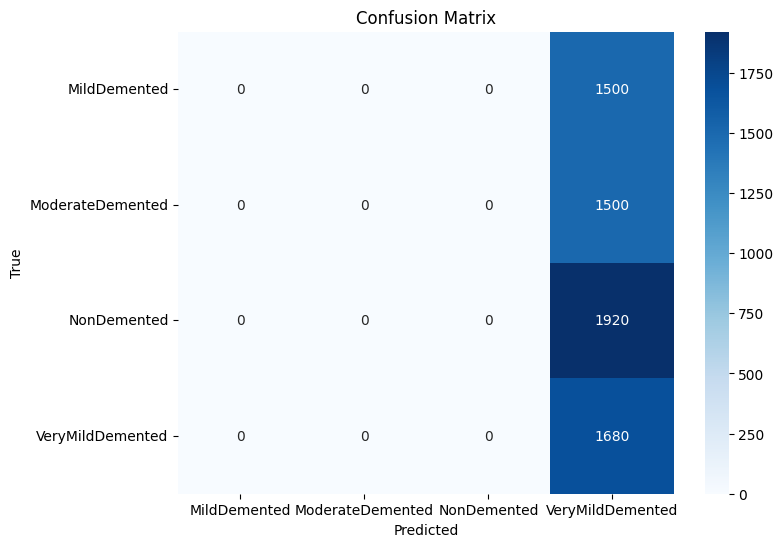

Confusion matrix saved to: /kaggle/working/results/efficientnet/confusion_matrix.png
Predictions saved to: /kaggle/working/results/efficientnet/test_predictions.csv
Per-class metrics saved to: /kaggle/working/results/efficientnet/per_class_metrics.csv


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
# Evaluate final model on test_gen (robust, saves results)
import os
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

# 1) Verify generator
try:
    assert not getattr(test_gen, 'shuffle', False), "Set test_gen.shuffle = False when creating generator"
except AssertionError as e:
    print("Warning:", e)

steps = len(test_gen)

# 2) Quick evaluate
loss, acc = model.evaluate(test_gen, steps=steps, verbose=1)
print(f"Test loss: {loss:.4f}, Test accuracy: {acc:.4f}")

# 3) Predictions for detailed metrics
pred_probs = model.predict(test_gen, steps=steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# True labels: prefer generator.classes if available
if hasattr(test_gen, 'classes'):
    y_true = test_gen.classes
else:
    # fallback: collect labels from generator
    y_true = []
    for X, y in test_gen:
        lab = y.numpy() if hasattr(y, 'numpy') else y
        y_true.extend(np.argmax(lab, axis=1))
    y_true = np.array(y_true)[:len(y_pred)]

# 4) Class names
if hasattr(test_gen, 'class_indices'):
    class_names = [k for k, v in sorted(test_gen.class_indices.items(), key=lambda x: x[1])]
else:
    class_names = [f'class_{i}' for i in range(pred_probs.shape[1])]

# 5) Reports & confusion matrix
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
os.makedirs(config.RESULTS_DIR, exist_ok=True)
plt.savefig(os.path.join(config.RESULTS_DIR, 'confusion_matrix.png'), bbox_inches='tight', dpi=150)
plt.show()
plt.close()
print(f"Confusion matrix saved to: {os.path.join(config.RESULTS_DIR, 'confusion_matrix.png')}")

# 6) Save per-sample predictions
rows = []
filenames = getattr(test_gen, 'filenames', None)
if filenames and len(filenames) >= len(y_pred):
    for fn, yt, yp in zip(filenames[:len(y_pred)], y_true, y_pred):
        rows.append({'filename': fn, 'y_true': int(yt), 'y_pred': int(yp)})
else:
    for i, (yt, yp) in enumerate(zip(y_true, y_pred)):
        rows.append({'index': i, 'y_true': int(yt), 'y_pred': int(yp)})

df = pd.DataFrame(rows)
out_csv = os.path.join(config.RESULTS_DIR, 'test_predictions.csv')
df.to_csv(out_csv, index=False)
print(f"Predictions saved to: {out_csv}")

# 7) Save per-class precision/recall/f1
p, r, f, s = precision_recall_fscore_support(y_true, y_pred, average=None)
summary = pd.DataFrame({
    'class': class_names,
    'precision': p,
    'recall': r,
    'f1': f,
    'support': s
})
summary.to_csv(os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv'), index=False)
print(f"Per-class metrics saved to: {os.path.join(config.RESULTS_DIR, 'per_class_metrics.csv')}")